# Capstone Project Pneumonia Image Recognition with CNN and tensorflow

# Problem Statement
How can images of infant chest X Rays be viewed algorithmically such that Pneumonia can be detected from Normal conditions with a level of confidence above 90%?

A Deep Learning algorithm of Convolution Neural Networks will be applied to images of pediatric X Rays separated into Pneumonia and Normal groups to determine if images can predict results based on training a model on the dataset

Images from the Kaggle Dataset: Pediatric Pneumonia Chest X-ray
https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

Code references from Towards Data Science: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Dataset by Daniel Kermany and Michael Goldbaum in 2018.  The data includes 5,856 images labelled as either pneumonia or normal 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [1]:
# typical imports
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt  # To visualize data
import numpy as np               # For arrays
import pandas as pd              # For holding and handling data
import seaborn as sns            # for confusion matrix plotting
from sklearn.metrics import accuracy_score, plot_confusion_matrix   # for metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score  # for metrics

# image processing imports
import cv2                       # For image to file handling
import glob                      # to read all files in directory

# for preprocessing the images
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,History
history = History()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

# for reading images from folders
from tensorflow.keras.preprocessing.image import DirectoryIterator  


# Load the data

In [2]:
# Define Overall Structure for modeling
# Directories for train, test, and validation datasets
source_data_path = 'CS_Pneumonia/source_data'
dataset_path = 'CS_Pneumonia/data'

# Batch size is number of trainging examples per iteration
batch_size = 20

# Dimension size of images set as 300x300 to limit loading on CPU of machine
img_height = 300
img_width = 300

In [3]:
# Identify the categorization and folder names for this dataset
categories = ['NORMAL','PNEUMONIA']
folders = ['train', 'test', 'valid']

# Exploratory Data Analysis

In [4]:
#Evaluate the pictures in the source folder
# read all files using glob method and record their features in DataFrame
file_list = []
for f in folders:                                 # train, test, or valid
    for c in categories:                          # pneumonia, normal
        for n in glob.glob(source_data_path+'/'+f+'/'+c+'/*.jpeg'):
            img = cv2.imread(n)
            # cv2.shape provides information for each image as 
            #height, width, number of channels of image
            width = img.shape[1]      # width
            height = img.shape[0]      # height
            ratio = height/width
            file_name = os.path.basename(n)
            info = [file_name,f,c,width,height,ratio]
            file_list.append(info)
                
print("pictures in database for modeling: ",len(file_list))
df_pics = pd.DataFrame(file_list)
df_pics.columns = ['File','Data Set','Result','Width','Height','Ratio']
df_pics.head()

pictures in database for modeling:  5856


,File,Data Set,Result,Width,Height,Ratio
0,NORMAL2-IM-0927-0001.jpeg,train,NORMAL,2359,2234,0.947011
1,NORMAL2-IM-1056-0001.jpeg,train,NORMAL,1422,1067,0.750352
2,IM-0427-0001.jpeg,train,NORMAL,1828,1357,0.742341
3,NORMAL2-IM-1260-0001.jpeg,train,NORMAL,1854,1495,0.806365
4,IM-0656-0001-0001.jpeg,train,NORMAL,2194,1966,0.896080


In [5]:
# Determine the typical ratio of Height/Width for the dataset
df_pics['Ratio'].describe()

count    5856.000000
mean        0.712905
std         0.117312
min         0.295964
25%         0.630616
50%         0.706272
75%         0.792627
max         1.197044
Name: Ratio, dtype: float64

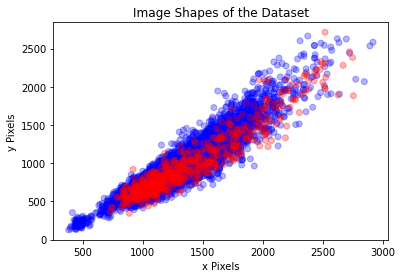

In [6]:
# Scatterplot of Width and Height parameters to show sizing
colors = df_pics['Data Set'].map({'train':'b', 'test':'r'})
fig, ax = plt.subplots()
ax.scatter(df_pics['Width'],df_pics['Height'],c=colors, alpha=0.3)
ax.set_xlabel("x Pixels")
ax.set_ylabel("y Pixels")
ax.set_title("Image Shapes of the Dataset")
plt.show()

In [7]:
# method to load files from source s_path to d_path, using cat for folder structure within
# changes images to grayscale and crops to width (w) x height (h) pixel size
# returns image array with label array aligned
def load_images(s_path,d_path,cat,w,h,min_size):
    ''' load_images moves files from source path string (s_path) to dest path string (d_path)
    making the images grayscale and resized to pixel count for height (h) by width (w)abs
    Exclusions for minimum pixel size (min_size), cat is category sub folder'''

    counter = 0
    fold = ['train','test']
    destination_path = d_path+'/'+cat
    for f in fold:
        source = s_path + '/' + f + '/' + cat
        print("Load Images Method: From ",source," to ",destination_path)        
        for file in glob.glob(source+'/*.jpeg'):
            img = cv2.imread(file)
            # compare image params, only resize and move if file meets size conditions
            if (img.shape[1] > min_size) and (img.shape[0] > min_size): 
                counter += 1
                
                file_name = os.path.basename(file)
                cv2.imwrite(destination_path+'/'+file_name,img)
    print("Files copied: ",counter," into ",cat)
    return counter

# Data Wrangling

In [8]:
# Establish destination directory folders
for f in folders:
    if not os.path.exists(dataset_path+'/'+f):
        os.makedirs(dataset_path+'/'+f)
    for c in categories:
        if not os.path.exists(dataset_path+'/'+f+'/'+c):
            os.makedirs(dataset_path+'/'+f+'/'+c)

In [9]:
# Load all the images from source folder into train folder. 
#(Combine both source test and train)
# Establish limits for files to be included in model
min_size = 200
    
norm_counts = load_images(source_data_path,dataset_path+'/train','NORMAL',img_width,img_height,min_size)
print("Normal Images in data folder: ",norm_counts)
pneu_counts = load_images(source_data_path,dataset_path+'/train','PNEUMONIA',img_width,img_height,min_size)
print("Pneumonia Images in data folder: ",pneu_counts)

Load Images Method: From  CS_Pneumonia/source_data/train/NORMAL  to  CS_Pneumonia/data/train/NORMAL
Load Images Method: From  CS_Pneumonia/source_data/test/NORMAL  to  CS_Pneumonia/data/train/NORMAL
Files copied:  1583  into  NORMAL
Normal Images in data folder:  1583
Load Images Method: From  CS_Pneumonia/source_data/train/PNEUMONIA  to  CS_Pneumonia/data/train/PNEUMONIA
Load Images Method: From  CS_Pneumonia/source_data/test/PNEUMONIA  to  CS_Pneumonia/data/train/PNEUMONIA
Files copied:  4240  into  PNEUMONIA
Pneumonia Images in data folder:  4240


In [10]:
# Move images into Test, Train, Valid folders
# Determine smallest group size, then take 10 percent for target valid,test files 
percent10 = min(norm_counts,pneu_counts)//10

check_folders = ['test','valid']
for f in check_folders:
    for c in categories:
        print('checking  ',dataset_path + '/train/' + c)
        for i in range(percent10):
            src = dataset_path + '/train/' + c
            dest = dataset_path + '/' + f + '/' + c
            random_file = random.choice(os.listdir(src))
            source_file = src + '/' + random_file
            shutil.move(source_file,dest)
        print('Moved ',i,'files from',src,' to ',dest)

# move extra files to discard folder

num_norm_files = len([f for f in os.listdir(dataset_path+'/train/NORMAL')if os.path.isfile(os.path.join(dataset_path+'/train/NORMAL', f))])
num_pneu_files = len([f for f in os.listdir(dataset_path+'/train/PNEUMONIA')if os.path.isfile(os.path.join(dataset_path+'/train/PNEUMONIA', f))])
print("Files remaining- NORMAL:",num_norm_files,". PNEUMONIA:",num_pneu_files)

if not os.path.exists(dataset_path + '/discard'):
        os.makedirs(dataset_path + '/discard')


checking   CS_Pneumonia/data/train/NORMAL
Moved  157 files from CS_Pneumonia/data/train/NORMAL  to  CS_Pneumonia/data/test/NORMAL
checking   CS_Pneumonia/data/train/PNEUMONIA
Moved  157 files from CS_Pneumonia/data/train/PNEUMONIA  to  CS_Pneumonia/data/test/PNEUMONIA
checking   CS_Pneumonia/data/train/NORMAL
Moved  157 files from CS_Pneumonia/data/train/NORMAL  to  CS_Pneumonia/data/valid/NORMAL
checking   CS_Pneumonia/data/train/PNEUMONIA
Moved  157 files from CS_Pneumonia/data/train/PNEUMONIA  to  CS_Pneumonia/data/valid/PNEUMONIA
Files remaining- NORMAL: 1267 . PNEUMONIA: 3924


In [11]:
# The remaining folder "/train/PNEUMONIA" has signficantly more files than "/train/NORMAL"
count=int((num_pneu_files - num_norm_files)*.8)
for i in range(count):
    src = dataset_path +'/train/PNEUMONIA'
    dest = dataset_path + '/discard'
    random_file = random.choice(os.listdir(src))
    source_file = src + '/' + random_file
    shutil.move(source_file,dest)
print('Moved ',i,'files from',src,' to ',dest)

Moved  2124 files from CS_Pneumonia/data/train/PNEUMONIA  to  CS_Pneumonia/data/discard


# Image Preprocessing
Read all images convert to Grayscale, size, prep for model

In [12]:
# Data PreProcessing
def image_preprocess(path):
    # Start empty list of each category (path) called
    images = []
    for i in path:
        # read the image
        img = cv2.imread(i)
        # resize
        img = cv2.resize(img,
                         dsize = (img_height,img_width), 
                         interpolation = cv2.INTER_CUBIC)
        # adjust brightness, contrast
        alpha = 1.0      # contrast
        beta = 1.0       # brightness
        img = cv2.addWeighted(img,
                              alpha,
                              np.zeros(img.shape, img.dtype),
                              0,beta)
        # convert grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        # Normalize the images 
        img = cv2.bitwise_not(img)
        img = img/255
        # append onto list of images
        images.append(img)
    # return the filled list of images
    return images

In [13]:
# Read files into the folders with preprocessing applied, observe image counts
# counts are [normal,pneumonia]
train_img_count, test_img_count, valid_img_count = [0,0], [0,0], [0,0]

# Training
img_train_normal = image_preprocess(path=glob.glob(dataset_path+"/train/NORMAL/*.jpeg"))
train_img_count[0] = len(img_train_normal)
img_train_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/train/PNEUMONIA/*.jpeg"))
train_img_count[1] = len(img_train_pneumonia)

# Testing
img_test_normal = image_preprocess(path=glob.glob(dataset_path+"/test/NORMAL/*.jpeg"))
test_img_count[0] = len(img_test_normal)
img_test_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/test/PNEUMONIA/*.jpeg"))
test_img_count[1] = len(img_test_pneumonia)

# Validation
img_valid_normal = image_preprocess(path=glob.glob(dataset_path+"/valid/NORMAL/*.jpeg"))
valid_img_count[0] = len(img_valid_normal)
img_valid_pneumonia = image_preprocess(path=glob.glob(dataset_path+"/valid/PNEUMONIA/*.jpeg"))
valid_img_count[1] = len(img_valid_pneumonia)

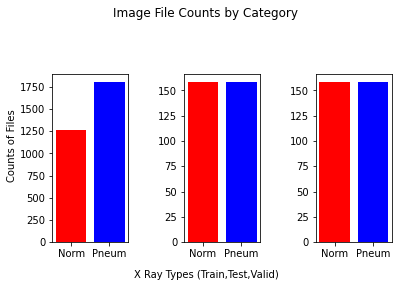

In [14]:
# Review file counts for all categories
fig, ax = plt.subplots(1, 3)
fig.suptitle('Image File Counts by Category')

#ax[0].set_color('r')
ax[0].bar(['Norm','Pneum'],train_img_count, color=['r','b'])
ax[1].bar(['Norm','Pneum'],test_img_count, color=['r','b'])
ax[2].bar(['Norm','Pneum'],valid_img_count, color=['r','b'])
fig.tight_layout(pad=3.0)
fig.text(0.5,0.04,'X Ray Types (Train,Test,Valid)', ha='center')
fig.text(0.04,0.5, 'Counts of Files', va='center', rotation='vertical')
plt.show()

In [15]:
# Create labels for the images
# Training
y_train_normal = [0 for i in range(0,len(img_train_normal))]
y_train_pneumonia = [1 for i in range(0,len(img_train_pneumonia))]
# Testing
y_test_normal = [0 for i in range(0,len(img_test_normal))]
y_test_pneumonia = [1 for i in range(0,len(img_test_pneumonia))]
# Validation
y_valid_normal = [0 for i in range(0,len(img_valid_normal))]
y_valid_pneumonia = [1 for i in range(0,len(img_valid_pneumonia))]

In [16]:
# Define  X_train, X_test, y_train, y_test for analysis
X_train = np.concatenate((img_train_normal, img_train_pneumonia), axis = 0)
X_test = np.concatenate((img_test_normal, img_test_pneumonia), axis = 0)
X_valid = np.concatenate((img_valid_normal, img_valid_pneumonia), axis = 0)
y_train = np.concatenate((y_train_normal, y_train_pneumonia), axis = 0)
y_test = np.concatenate((y_test_normal, y_test_pneumonia), axis = 0)
y_valid = np.concatenate((y_valid_normal, y_valid_pneumonia), axis = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(3066, 300, 300)
(3066,)
(316, 300, 300)
(316,)
(316, 300, 300)
(316,)


In [17]:
# Create method to accept X,y arrays, shuffle the order
# Then return arrays that maintain labels and are randomized, return as np.array
def shuffle_label_array(arrays,labels):
    org_images = []
    for i,j in enumerate(arrays):
        # brings images and labels together into same array
        new_array = (j,labels[i])
        org_images.append(new_array)  # append onto the array
    temp_array = np.array(org_images)
    np.random.shuffle(temp_array)     # shuffle the array
# Now split back apart keeping the order association for separate lists
    X_data = []                    # temporary X array
    y_data = []                    # temporary y array
    for a in temp_array:
        # pull images and labels apart
        X_data.append(a[0])        # image
        y_data.append(a[1])        # label
    return np.array(X_data), np.array(y_data)

In [18]:
# Call method to split arrays apart but still have y array with correct labels associated, verify sizes again
X_train,y_train = shuffle_label_array(X_train,y_train)
print(X_train.shape)
print(y_train.shape)
X_test,y_test = shuffle_label_array(X_test,y_test)
print(X_test.shape)
print(y_test.shape)
X_valid,y_valid = shuffle_label_array(X_valid,y_valid)
print(X_valid.shape)
print(y_valid.shape)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


(3066, 300, 300)
(3066,)
(316, 300, 300)
(316,)
(316, 300, 300)
(316,)


In [19]:
# Reshaping the X data
# Reshape the data into (no of samples, height, width, 1) where 1 represents single color channel grayscale
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3066, 300, 300, 1)
(316, 300, 300, 1)
(316, 300, 300, 1)


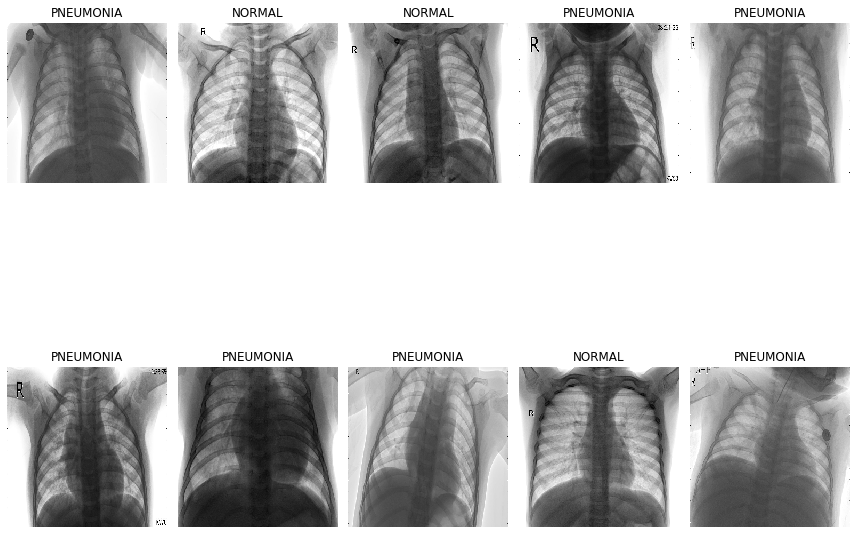

In [20]:
# View images
# Display batch of images to see results of import
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(2,5,i+1)
    for index in range(len(X_train)):
        image = X_train[i]        
        dic = {0:'NORMAL',1:'PNEUMONIA'}
        plt.title(dic.get(y_train[i]))   # labels imbeded based on folder structure of data on build
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray', interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Modeling

# CNN Model Build
Convolutional layers: (input data image with 2D convolutional layers) Creates feature map. Depth of filter same as depth of input- grayscale is 1.  Will apply a Sequential model to allow us to build layer by layer

Determining the dimension of activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file
P = Padding
F = Dimension of filter
S = Stride

ReLu layers: (Rectified Linear Unit - linear function to output directly if positive, otherwise zero) Increases non-linearity. _Better than Sigmoid and Tanh based on overcoming the vanishing gradient problem.

Pooling layers: Combine to create spatial variance, make objects detectable no matter where they are located in the image

Flattening: make long vector of pooled features

Fully connect layer: Input vector into neural network.  Process features through the network.  The fully connected layers votes on the classes

Train the model: using forward propagation and backpropagation, trains the neural network with weights and feature detectors


In [21]:
# Method to Display results for model
def model_results(m,xt,yt):    # m-model, xt-X_test data, yt- y_test labels

    print('*****  RESULTS  *****')
    #model_results(model,test_data,test_labels,valid)
    print("test data set size: ",len(xt))
    predictions = m.predict(xt)
    # turn predictions into 0 and 1 values. Sigmoid output is 0 to 1 so split on 0.5
    predictions_values = []
    for i in predictions:
        if i < 0.5:
            predictions_values.append(0)
        if i >= 0.5:
            predictions_values.append(1)

    # Plot confusion matrix
    print('*****  Confusion Matrix  *****')
    cm = confusion_matrix(yt, predictions_values)
    print(cm)

    print('*****  Classification Report  *****')
    print(classification_report(yt,predictions_values,target_names=categories))

    print('*****  Metric Scores  *****')
    # accuracy: (tp + tn_ / (p + n)
    accuracy = accuracy_score(yt,predictions_values)
    print('Accuracy : %f' % accuracy)

    # precision: tp / (tp + fp)
    precision = precision_score(yt,predictions_values)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(yt,predictions_values)
    print('Recall   : %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yt,predictions_values)
    print('F1 score : %f' % f1)
    
    # show heatmap of confusion matrix
    sns.heatmap(cm, cbar=False, xticklabels=categories, yticklabels=categories, fmt='d', annot=True, cmap=plt.cm.Reds)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Create the first model

In [22]:
# Create the model
model = Sequential()

# Add model layers
model.add(Conv2D(32, (3,3),
                activation='relu',kernel_initializer='he_uniform',padding='same',
                input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)
          
# Now flatten the layers
model.add(Flatten())

# Use Dense to lower shape down to 1 output
model.add(Dense(128,activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dense(1,activation='sigmoid'))

In [23]:
# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#   optimizer controls the learning rate: 
#.    "Adam" good general use-adjusts lerning rate throughout training
#   loss function: binary_crossentropy, for binary (2 choice) problems
#   metrics: accuracy

In [24]:
# Look at model summary to determine layer sizes
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 720000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               92160128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 92,160,577
Trainable params: 92,160,577
Non-trainable params: 0
_________________________________________________________________


# Fit The Model

In [25]:
# MODEL 1
# Set a validation set of data to set early stopping point for model fit
my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(3066, 300, 300, 1)
(3066,)
(316, 300, 300, 1)
(316,)
(316, 300, 300, 1)
(316,)


In [26]:
# fit the model
history = model.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
96/96 [==============================] - 66s 666ms/step - loss: 0.8643 - accuracy: 0.6667 - val_loss: 0.5902 - val_accuracy: 0.5728
Epoch 2/25
96/96 [==============================] - 63s 656ms/step - loss: 0.4898 - accuracy: 0.7792 - val_loss: 0.4510 - val_accuracy: 0.7880
Epoch 3/25
96/96 [==============================] - 64s 662ms/step - loss: 0.2888 - accuracy: 0.8748 - val_loss: 0.2340 - val_accuracy: 0.9177
Epoch 4/25
96/96 [==============================] - 63s 661ms/step - loss: 0.2614 - accuracy: 0.8894 - val_loss: 0.2283 - val_accuracy: 0.9272
Epoch 5/25
96/96 [==============================] - 63s 657ms/step - loss: 0.2603 - accuracy: 0.8940 - val_loss: 0.2561 - val_accuracy: 0.8956
Epoch 6/25
96/96 [==============================] - 62s 651ms/step - loss: 0.2750 - accuracy: 0.8920 - val_loss: 0.2561 - val_accuracy: 0.9082


<AxesSubplot:>

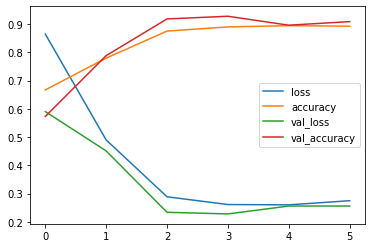

In [27]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(history.history).plot()

In [28]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

Training Accuracy based on Test Dataset
Model loss is :  23.71629923582077 %
Model Accuracy is :  90.82278609275818 %


*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[134  24]
 [  5 153]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.96      0.85      0.90       158
   PNEUMONIA       0.86      0.97      0.91       158

    accuracy                           0.91       316
   macro avg       0.91      0.91      0.91       316
weighted avg       0.91      0.91      0.91       316

*****  Metric Scores  *****
Accuracy : 0.908228
Precision: 0.864407
Recall   : 0.968354
F1 score : 0.913433


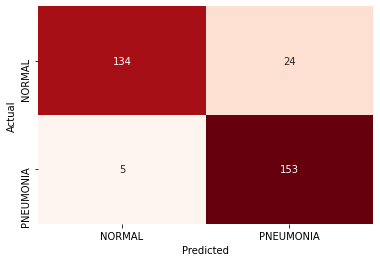

In [29]:
# Call method to Display Results for model 1
model_results(model,X_test,y_test)

# Improving the Model (Model2)
The results from the first model did meet expectations 
The graph shows multiple epochs with high accuracy and low loss with resultant accuracy applying the test set was above expectations at 92%  The confusion matrix listed a balance at 16 False Positives and 9 False Negatives. 

The model was run with (alpha, beta) values ranging from (0.8,0.8) to (1.1,1.1) with combinations in between. 
For values alpha=1.0 and beta=1.0 the best results occurred. The early stopping rules ended the formation after 7 Epochs after meeting the rule of Accuracy change below 0.01 for patience of 2.

To see if these results can be improved, additional layers are added to model and the Dense add will be changed to 64 units

In [30]:
# Create the model
model2 = Sequential()

# Add model layers
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model2.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model2.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model2.add(MaxPooling2D(pool_size = (2,2)))      
    
    
# Now flatten the layers
model2.add(Flatten())

# Use Dense to lower shape down to 1 output
model2.add(Dense(64,activation ='relu'))
model2.add(Dense(1,activation='sigmoid'))

# Set a validation set of data to set early stopping point for model fit
my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Look at model2 summary to determine layer sizes
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)            

In [32]:
# fit the updated model2
history2 = model2.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
96/96 [==============================] - 92s 956ms/step - loss: 0.3653 - accuracy: 0.8392 - val_loss: 0.2236 - val_accuracy: 0.9051
Epoch 2/25
96/96 [==============================] - 92s 956ms/step - loss: 0.1657 - accuracy: 0.9393 - val_loss: 0.1705 - val_accuracy: 0.9335
Epoch 3/25
96/96 [==============================] - 92s 954ms/step - loss: 0.1406 - accuracy: 0.9478 - val_loss: 0.1400 - val_accuracy: 0.9525
Epoch 4/25
96/96 [==============================] - 91s 944ms/step - loss: 0.1113 - accuracy: 0.9589 - val_loss: 0.1241 - val_accuracy: 0.9589
Epoch 5/25
96/96 [==============================] - 91s 947ms/step - loss: 0.1012 - accuracy: 0.9612 - val_loss: 0.1243 - val_accuracy: 0.9494
Epoch 6/25
96/96 [==============================] - 90s 934ms/step - loss: 0.0811 - accuracy: 0.9720 - val_loss: 0.1287 - val_accuracy: 0.9620
Epoch 7/25
96/96 [==============================] - 90s 943ms/step - loss: 0.0699 - accuracy: 0.9752 - val_loss: 0.1613 - val_accuracy: 0.9462

<AxesSubplot:>

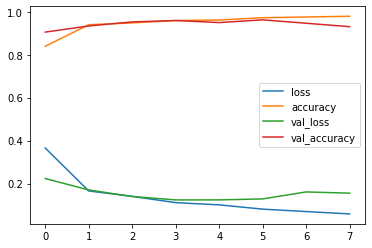

In [33]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(history2.history).plot()

In [34]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model2.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

Training Accuracy based on Test Dataset
Model loss is :  13.068167865276337 %
Model Accuracy is :  95.88607549667358 %


*****  Model 2  *****
*****  RESULTS  *****
test data set size:  316
*****  Confusion Matrix  *****
[[153   5]
 [  8 150]]
*****  Classification Report  *****
              precision    recall  f1-score   support

      NORMAL       0.95      0.97      0.96       158
   PNEUMONIA       0.97      0.95      0.96       158

    accuracy                           0.96       316
   macro avg       0.96      0.96      0.96       316
weighted avg       0.96      0.96      0.96       316

*****  Metric Scores  *****
Accuracy : 0.958861
Precision: 0.967742
Recall   : 0.949367
F1 score : 0.958466


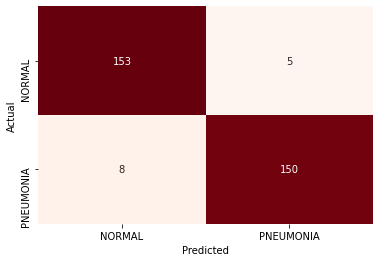

In [35]:
# Display Results for model 2
print('*****  Model 2  *****')
model_results(model2,X_test,y_test)

# Improving the Model a third time (Model3)
The results from the second model were better than Model 1, Accuracy of 96%. Improved confusion matrix with a balance at 8 False Positives (model1 had 16) and 4 False Negatives (model1 had 9).  These results met expectations, but were better for all measures.  The additional 2 layers in the model lowered the trainable parameters, but made the model work better.

The model was run with (alpha, beta) values ranging from (0.8,0.8) to (1.1,1.1) with combinations in between. For values alpha=1.0 and beta=1.0 the best results occurred. The early stopping rules ended the formation after 7 Epochs after meeting the rule of Accuracy change below 0.01 for patience of 2.

To see if these results can be improved, additional layers are added to model to see if further improvements can be made

In [36]:
# Create the model
model3 = Sequential()

# Add model layers
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D((2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model3.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2)))      

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2))) 

# Add another model layer to further reduce shape
model3.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model3.add(MaxPooling2D(pool_size = (2,2))) 
    
    
# Now flatten the layers
model3.add(Flatten())

# Use Dense to lower shape down to 1 output
model3.add(Dense(activation = 'relu', units=32))
model3.add(Dense(activation='sigmoid', units=1))
# Set a validation set of data to set early stopping point for model fit
my_callbacks = [EarlyStopping(monitor='accuracy', mode='max', min_delta= 0.01, patience = 2)]
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Look at model3 summary to determine layer sizes
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 64)       

In [ ]:
# fit the updated model3
history3 = model3.fit(X_train, y_train, epochs = 25, validation_data=(X_valid,y_valid), callbacks=my_callbacks)

Epoch 1/25
96/96 [==============================] - 90s 939ms/step - loss: 0.4250 - accuracy: 0.7922 - val_loss: 0.2726 - val_accuracy: 0.8987
Epoch 2/25
96/96 [==============================] - 91s 948ms/step - loss: 0.2520 - accuracy: 0.9005 - val_loss: 0.2075 - val_accuracy: 0.9335
Epoch 3/25
96/96 [==============================] - 89s 932ms/step - loss: 0.2082 - accuracy: 0.9145 - val_loss: 0.1711 - val_accuracy: 0.9304
Epoch 4/25
96/96 [==============================] - 91s 947ms/step - loss: 0.1718 - accuracy: 0.9305 - val_loss: 0.1416 - val_accuracy: 0.9335
Epoch 5/25
96/96 [==============================] - 89s 926ms/step - loss: 0.1609 - accuracy: 0.9377 - val_loss: 0.1249 - val_accuracy: 0.9430
Epoch 6/25
96/96 [==============================] - 90s 933ms/step - loss: 0.1448 - accuracy: 0.9442 - val_loss: 0.1304 - val_accuracy: 0.9525
Epoch 7/25
96/96 [==============================] - 89s 925ms/step - loss: 0.1345 - accuracy: 0.9491 - val_loss: 0.1681 - val_accuracy: 0.9462

In [ ]:
#Visualize the progress of the metrics throughout the epocks
pd.DataFrame(model3.history.history).plot()

In [ ]:
print('Training Accuracy based on Test Dataset')
test_accuracy = model3.evaluate(X_test,y_test,verbose=0)
print('Model loss is : ',test_accuracy[0]*100,'%')
print('Model Accuracy is : ',test_accuracy[1]*100,'%')

In [ ]:
# Display Results for model 3
print('*****  Model 3  *****')
model_results(model3,X_test,y_test)

# Conclusion
After three different model applications on the same datasets, the highest validation accuracy achieved was using the 2nd model with 3 layers (Model 2) with an accuracy of 95.6% and a loss of 12.6.

The first model did not run well, with high loss values, but the other two models had accuracy results above 94.6%.  Model 2 and 3 were similar, but had a slight bias difference in their confusion matrix.